In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime

import statsmodels.formula.api as smf
from saturation.utils import *

import matplotlib.pyplot as plt

# Configuration

In [13]:
BASE_PATH = "/data/saturation/thesis_run_20250223/"

# Simulation IDs for the training set
MIN_SIMULATION_ID = 1
MAX_SIMULATION_ID = 150
simulation_ids = list(range(MIN_SIMULATION_ID, MAX_SIMULATION_ID + 1))

FONT_SIZE = 22
DPI = 400
IMAGE_TYPE = "svg"

# Modeling each simulation separately

In [4]:
configs_df = read_configs_pandas(base_path=BASE_PATH)
configs_dict = configs_df.set_index("simulation_id").to_dict(orient="index")

In [5]:
statistics_by_simulation_id = []
for simulation_id in simulation_ids:
    statistics = pd.read_parquet(f"data/statistics_{simulation_id}.parquet")
    statistics_by_simulation_id.append(statistics)
statistics = pd.concat(statistics_by_simulation_id, axis=0)

In [6]:
formula = "lifespan ~ 1 + np.log(radius)"
models_by_id = dict()

for simulation_id in simulation_ids:
    print(f"Starting {simulation_id} at {datetime.datetime.now()}")
    d = statistics.loc[simulation_id].sample(frac=0.1).copy()

    # Fit a negative binomial model
    try:
        model = smf.negativebinomial(data=d, formula=formula).fit(maxiter=1000, method="Powell", disp=0)
        models_by_id[simulation_id] = model
    except:
        print(f"Failed to fit {simulation_id}")

Starting 1 at 2025-03-21 11:36:16.288895
Starting 2 at 2025-03-21 11:36:17.379418
Starting 3 at 2025-03-21 11:36:17.976409
Starting 4 at 2025-03-21 11:36:18.672438
Starting 5 at 2025-03-21 11:36:19.349552
Starting 6 at 2025-03-21 11:36:20.058187
Starting 7 at 2025-03-21 11:36:20.793442
Starting 8 at 2025-03-21 11:36:21.405161
Starting 9 at 2025-03-21 11:36:22.016194
Starting 10 at 2025-03-21 11:36:22.652602
Starting 11 at 2025-03-21 11:36:23.276042
Starting 12 at 2025-03-21 11:36:24.147625
Starting 13 at 2025-03-21 11:36:24.898388
Starting 14 at 2025-03-21 11:36:25.716160
Starting 15 at 2025-03-21 11:36:26.789928
Starting 16 at 2025-03-21 11:36:27.494091
Starting 17 at 2025-03-21 11:36:28.265068
Starting 18 at 2025-03-21 11:36:28.878855
Starting 19 at 2025-03-21 11:36:29.484324
Starting 20 at 2025-03-21 11:36:30.076998
Starting 21 at 2025-03-21 11:36:30.677180
Starting 22 at 2025-03-21 11:36:31.443301
Starting 23 at 2025-03-21 11:36:32.130982
Starting 24 at 2025-03-21 11:36:33.011160
S

In [7]:
columns = [
    "simulation_id",
    "slope"    
]
estimates = configs_df[configs_df.simulation_id.isin(models_by_id.keys())][columns].copy()
estimates["rim_erasure_exponent"] = [configs_dict[x]["rim_erasure_method"]["exponent"] for x in estimates.simulation_id]
estimates["beta1"] = [models_by_id[x].params.iloc[1] for x in estimates.simulation_id]
estimates["beta1_std_err"] = [models_by_id[x].bse.iloc[1] for x in estimates.simulation_id]
estimates["beta1_pvalue"] = [models_by_id[x].pvalues.iloc[1] for x in estimates.simulation_id]
estimates["llr_pvalue"] = [models_by_id[x].llr_pvalue for x in estimates.simulation_id]
estimates["dispersion_statistic"] = [
    np.sum(models_by_id[x].resid_pearson**2) / models_by_id[x].df_resid
    for x in estimates.simulation_id
]

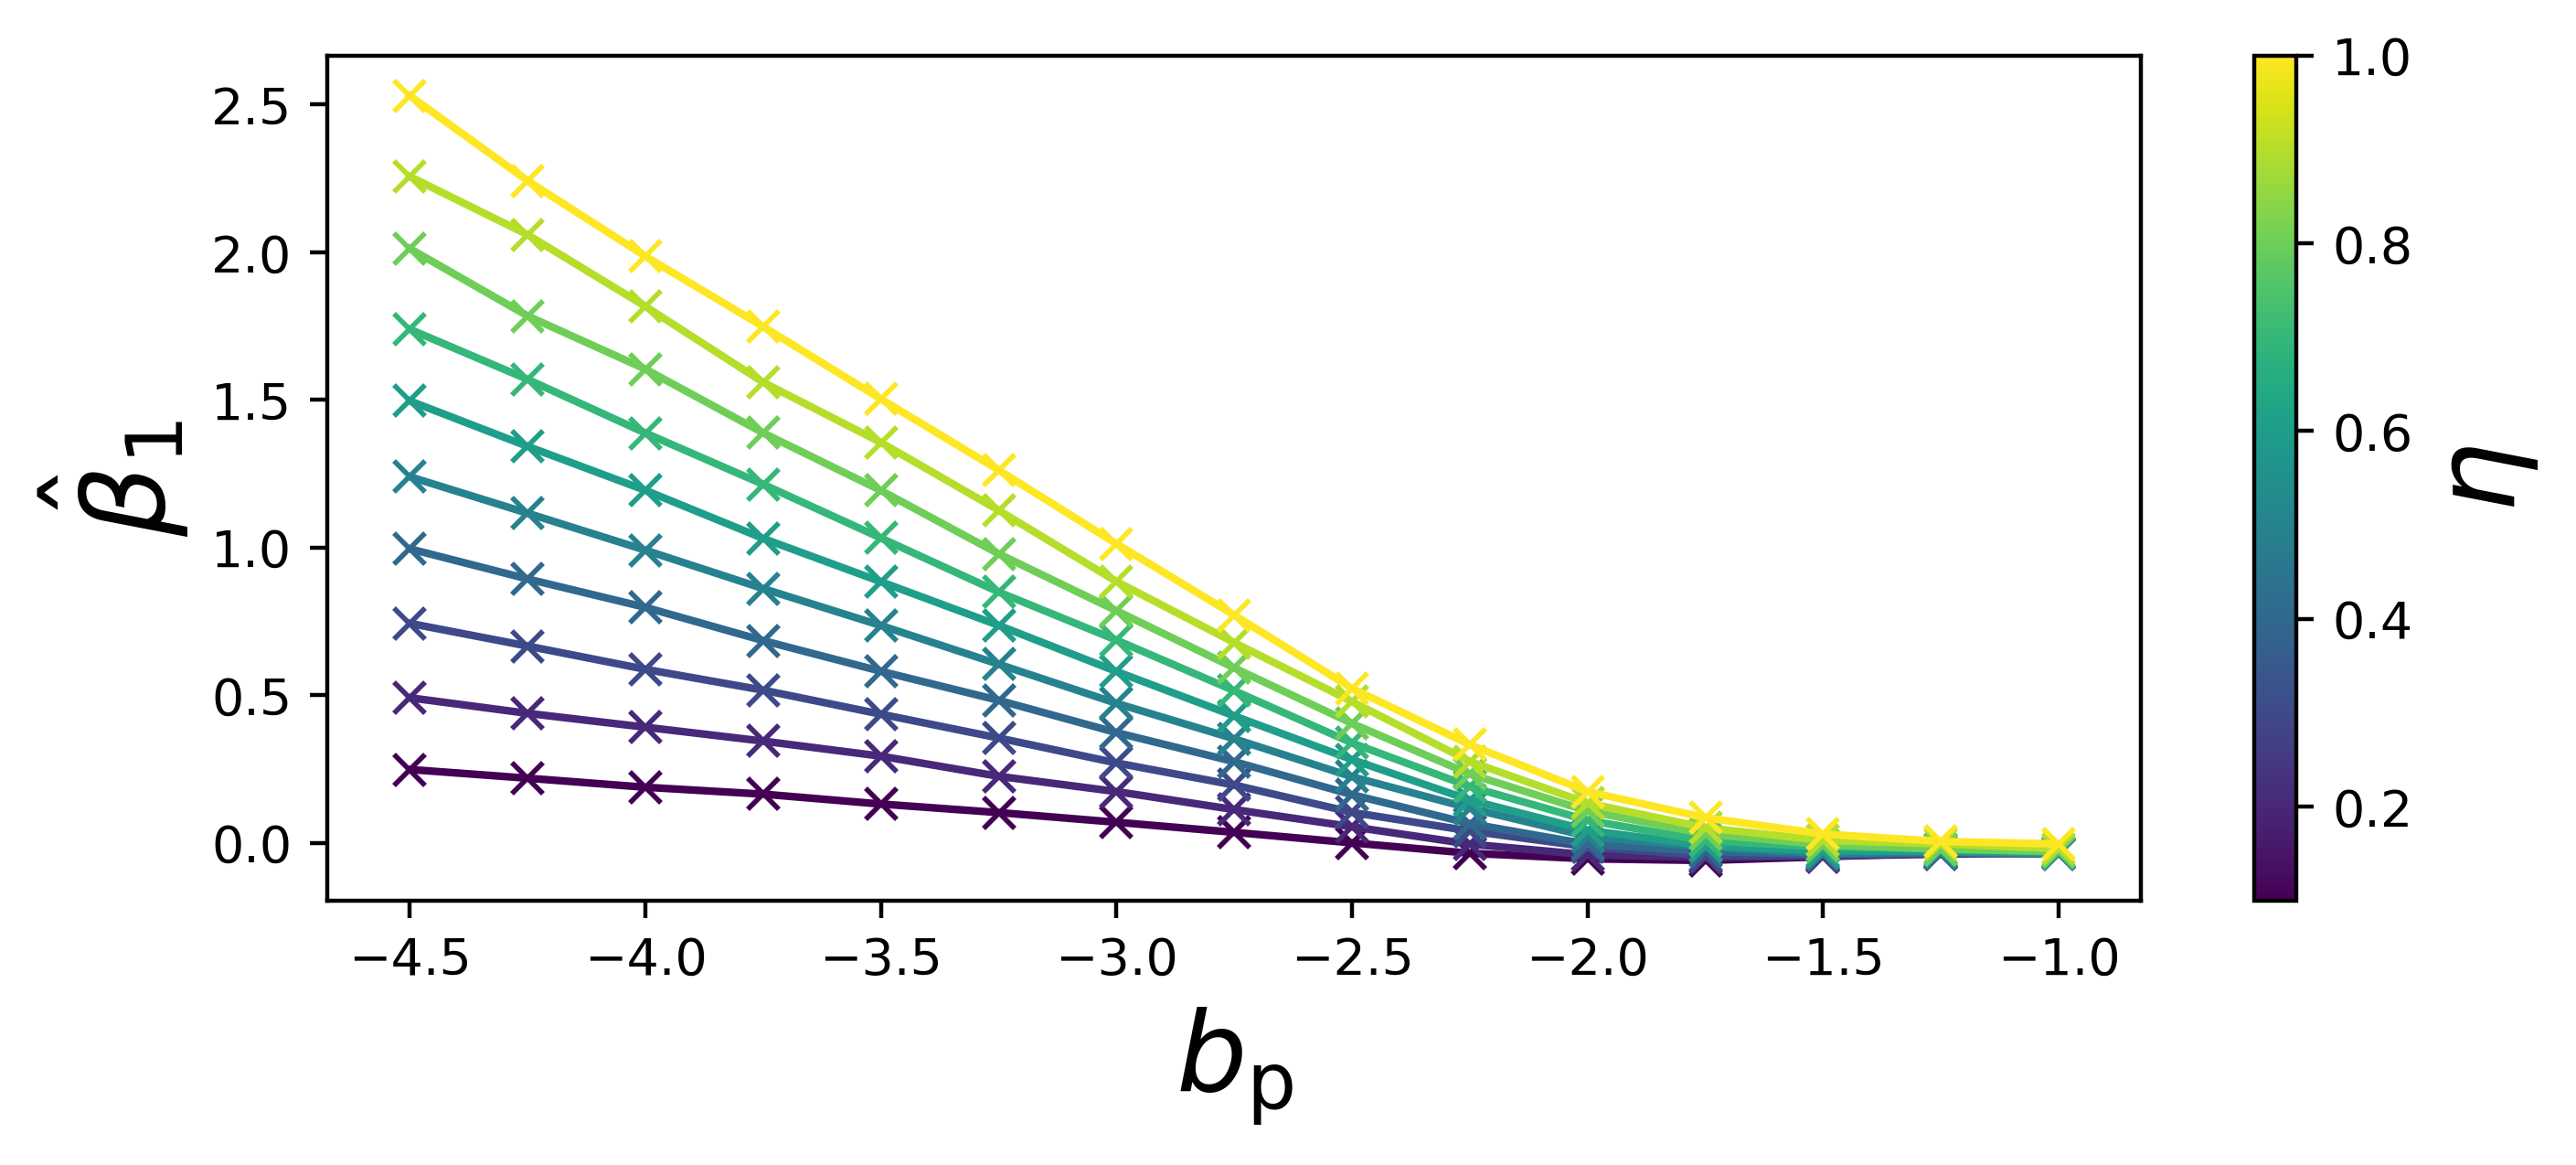

In [14]:
fig = plt.figure(figsize=(8, 3), dpi=DPI)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(estimates["rim_erasure_exponent"].min(), estimates["rim_erasure_exponent"].max())

for rim_erasure_exponent in estimates.rim_erasure_exponent.drop_duplicates().sort_values():
    d = estimates[estimates.rim_erasure_exponent == rim_erasure_exponent].sort_values("slope").copy()
    ax.errorbar(
        d.slope,
        d.beta1,
        d.beta1_std_err,
        marker="x",
        # ls="",
        color=plt.cm.viridis(norm(rim_erasure_exponent)),
        ecolor=plt.cm.viridis(norm(rim_erasure_exponent))
    )

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\eta$", fontsize=FONT_SIZE)

ax.set_xlabel(r"$b_{\text{p}}$", fontsize=FONT_SIZE)
ax.set_ylabel(r"$\hat{\beta}_1$", fontsize=FONT_SIZE)

plt.savefig(f"figures/stratified_model_slopes_by_simulation.{IMAGE_TYPE}", bbox_inches="tight")
plt.show()

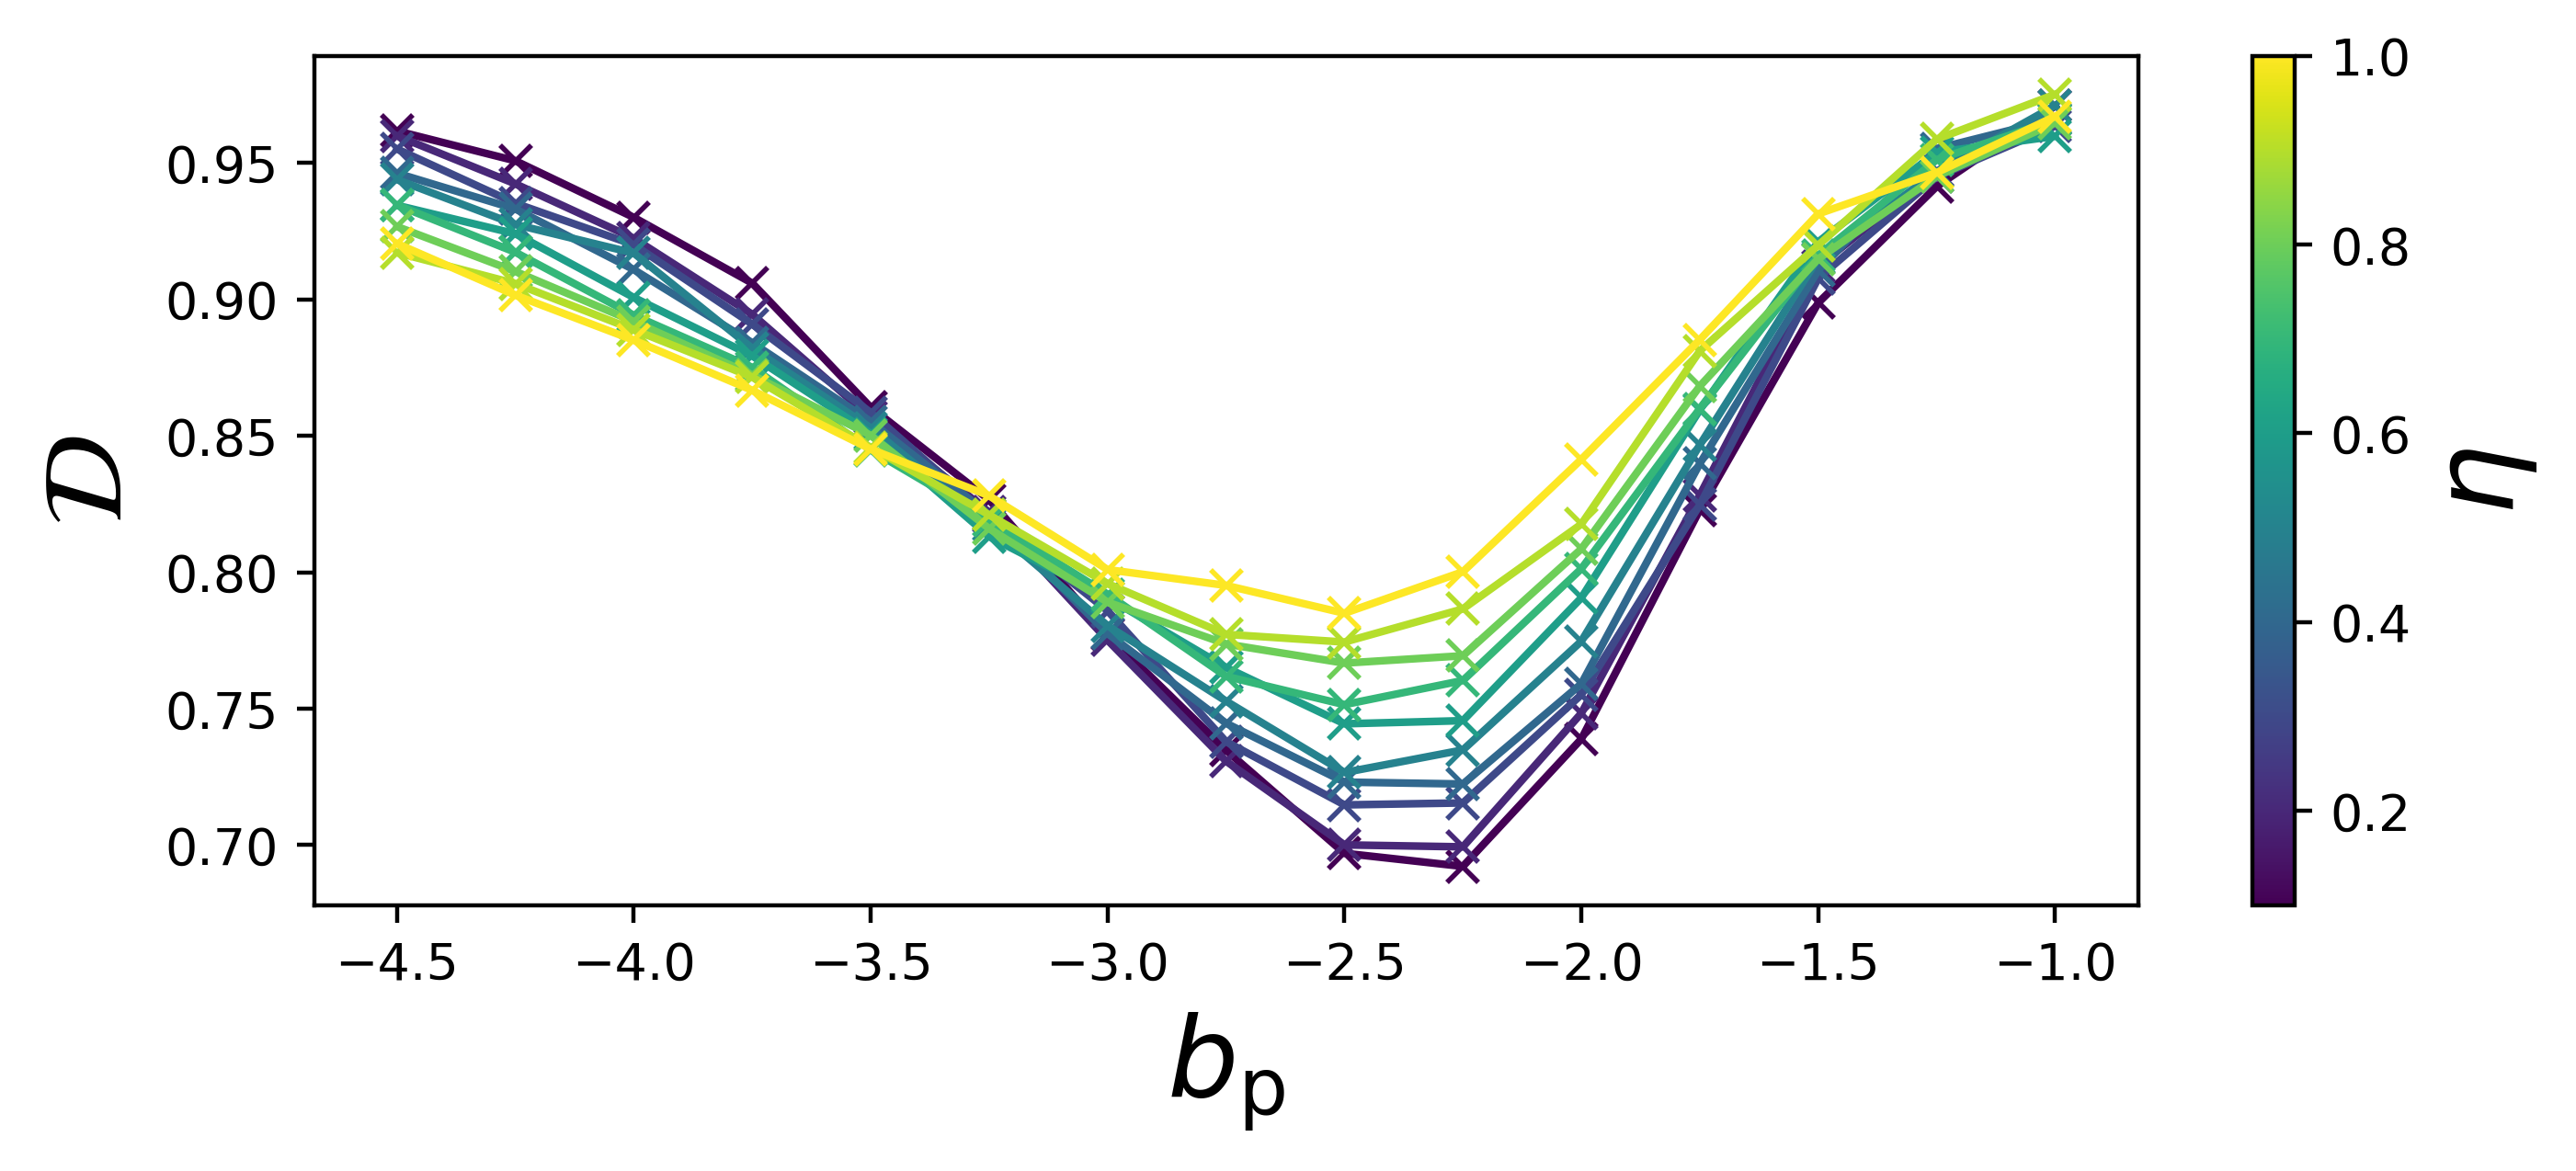

In [15]:
fig = plt.figure(figsize=(8, 3), dpi=DPI)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(estimates["rim_erasure_exponent"].min(), estimates["rim_erasure_exponent"].max())

for rim_erasure_exponent in estimates.rim_erasure_exponent.drop_duplicates().sort_values():
    d = estimates[estimates.rim_erasure_exponent == rim_erasure_exponent].sort_values("slope").copy()
    ax.plot(
        d.slope,
        d.dispersion_statistic,
        marker="x",
        color=plt.cm.viridis(norm(rim_erasure_exponent)),
    )

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\eta$" ,fontsize=FONT_SIZE)

ax.set_xlabel(r"$b_{\text{p}}$", fontsize=FONT_SIZE)
ax.set_ylabel(r"$\mathcal{D}$", fontsize=FONT_SIZE)

plt.savefig(f"figures/stratified_model_dispersion_by_simulation.{IMAGE_TYPE}", bbox_inches="tight")
plt.show()

## What"s with the insignificant p-values?

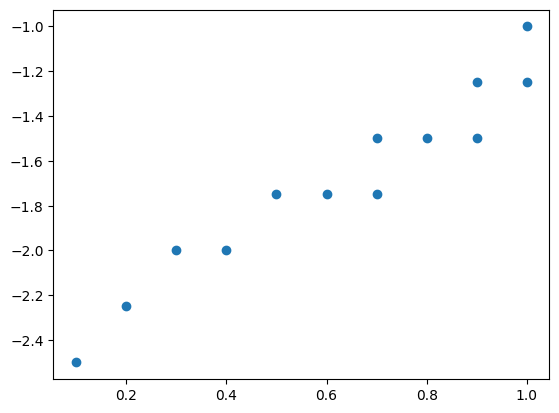

In [16]:
# We have some suspect p-values
large_pvalues = estimates[estimates["beta1_pvalue"] > 1e-3].sort_values("slope")

plt.scatter(
    large_pvalues.rim_erasure_exponent,
    large_pvalues.slope
)

# Output a LaTeX table of p-values

In [17]:
def significance_marker(p: float) -> str:
    """Assign significance markers based on p-value thresholds."""
    if p < 0.001:
        return "*"
    elif p < 0.05:
        return "x"
    else:
        return ""

def format_pvalue(p: float) -> str:
    """Format p-value, aligning numbers neatly even with significance markers."""
    marker = significance_marker(p)
    if p < 0.001:
        return marker
    else:
        return f"{p:<5.3f}"

def create_pvalue_table(
    df: pd.DataFrame,
    *,
    field: str,
    exponent_digits: int = 1,
    slope_digits: int = 2
) -> str:
    """Generate a formatted LaTeX table summarizing p-values significance."""
    pivot_table = df.rename(columns={"rim_erasure_exponent": "eta"}).pivot_table(
        index="slope",
        columns="eta",
        values=field,
        aggfunc="mean"
    )

    pivot_table.index = pivot_table.index.map(lambda x: fr"\textbf{{{x:.{slope_digits}f}}}")
    pivot_table.columns = pivot_table.columns.map(lambda x: fr"\textbf{{{x:.{exponent_digits}f}}}")

    formatted_table = pivot_table.map(
        lambda p: fr"\textbf{{{format_pvalue(p)}}}" if significance_marker(p) else format_pvalue(p) if pd.notna(p) else ""
    )

    latex_table = formatted_table.to_latex(
        caption="",
        label="tab:pvalue_summary",
        na_rep="",
        escape=False,
        column_format="r" + "r" * formatted_table.shape[1],
        index_names=False,
        index=True
    )

    # Add clearer headers for exponent and slope
    latex_table = latex_table.replace(
        r"\toprule",
        r"\toprule \\"
        + "\n"
        + r"\textbf{b} & \multicolumn{"
        + f"{formatted_table.shape[1]}"
        + r"}{c}{\textbf{$\eta$}} \\"
        + "\n"
        rf"\cmidrule(lr){{2-{formatted_table.shape[1] + 1}}}"
    )

    return latex_table

In [18]:
print(create_pvalue_table(estimates, field="beta1_pvalue"))

\begin{table}
\label{tab:pvalue_summary}
\begin{tabular}{rrrrrrrrrrr}
\toprule \\
\textbf{b} & \multicolumn{10}{c}{\textbf{$\eta$}} \\
\cmidrule(lr){2-11}
eta & \textbf{0.1} & \textbf{0.2} & \textbf{0.3} & \textbf{0.4} & \textbf{0.5} & \textbf{0.6} & \textbf{0.7} & \textbf{0.8} & \textbf{0.9} & \textbf{1.0} \\
\midrule
\textbf{-4.50} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} \\
\textbf{-4.25} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} \\
\textbf{-4.00} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} \\
\textbf{-3.75} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} \\
\textbf{-3.50} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \textbf{*} & \text